<a href="https://colab.research.google.com/github/silviasd2025-bit/dea_studies/blob/main/20250919_malmq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import relevant libraries
- Will use Pyomo for mathematical optimization
- Data source: Tom

# Malmquist Productivity Index, Technical Efficiency and Efficiency Change
## Energy

In [2]:
!apt-get install -y -qq glpk-utils > /dev/null 2>&1

In [3]:
from pyomo.environ import (ConcreteModel, Var, Objective, Constraint,
                           SolverFactory, minimize, maximize, NonNegativeReals,
                           ConstraintList, TerminationCondition)
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import io
import os
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Get the path to the glpsol executable
glpk_executable_path = '/usr/bin/glpsol'  # Update with the actual path if different

# Set the solver path in the SolverFactory call
solver = SolverFactory('glpk', executable=glpk_executable_path)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Data and Variables

We used data from two time periods, 2014 and 2022, to calculate the Malmquist Productivity Index (MPI) and its decomposition into technical change and efficiency change.



In [7]:
#uploaded = files.upload()
file_path = "/content/drive/MyDrive/data/20250914_DEA_EnergySecurityPaper2.csv"
df = pd.read_csv(file_path)
df_2014 = df[df["year"] == 2014]
df_2022 = df[df["year"] == 2022]
df_2014[:20]

,Unnamed: 0,dmu,year,installed_capacity_per_capita,energy_diversification,energy_export,percentage_renewable,mwh_capita,gdp_capita,electrification,carbon_intensity,inverse_carbon_intensity
14,14,Argentina,2014,0.881,3794.220973,-14.067810,10.396,0.003288,12233.144412,100.0,424.13745,0.002358
38,38,Australia,2014,2.078,4460.109549,185.555789,5.663,0.010496,62544.087377,100.0,734.18134,0.001362
62,62,Brazil,2014,0.544,4316.643494,-14.281473,37.566,0.002951,12274.993969,99.7,192.93880,0.005183
86,86,Canada,2014,3.908,3916.466444,66.764578,27.026,0.018324,50960.843117,100.0,188.86014,0.005295
110,110,China,2014,1.006,5615.278555,-17.557385,9.690,0.004175,7781.065975,100.0,693.72760,0.001441
134,134,EU27,2014,1.736,1881.543230,-63.669640,14.118,0.006375,35592.887488,100.0,369.34964,0.002707
158,158,France,2014,1.787,6092.567214,-47.903750,9.885,0.008754,43148.045929,100.0,52.19756,0.019158
182,182,Germany,2014,2.181,2518.528853,-64.035236,12.840,0.007604,48971.082472,100.0,521.68085,0.001917
206,206,India,2014,0.186,5829.264441,-36.565941,6.829,0.000962,1553.883961,85.1,741.50310,0.001349
230,230,Indonesia,2014,0.155,3382.223800,123.004442,4.708,0.000918,3441.068085,97.0,691.58880,0.001446


##Data Preparation and Normalization

Our analysis employs a Data Envelopment Analysis (DEA) framework to calculate the Malmquist Productivity Index (MPI) and its components. The input variables comprise population development, health workforce, women's education, water access, and nutrition indicators, while the output variable is child survival rates. All variables are log-transformed to address potential scale effects and heteroscedasticity.

In [8]:
# Select Inputs and outputs for the MPI, TE, and EC
inputs_2014 = df_2014[['installed_capacity_per_capita', 'energy_diversification',
                       'energy_export', 'percentage_renewable']].values
outputs_2014 = df_2014[['mwh_capita', 'gdp_capita', 'inverse_carbon_intensity']].values

inputs_2014 = df_2022[['installed_capacity_per_capita', 'energy_diversification',
                       'energy_export', 'percentage_renewable']].values
outputs_2014 = df_2022[['mwh_capita', 'gdp_capita', 'inverse_carbon_intensity']].values
#inputs_2022 = df_2022[['l_pop_dev', 'l_healthworkforce']].values
#outputs_2022 = df_2022[['l_childsurvival']].values

To ensure numerical stability and comparable scales across variables, we implement a robust normalization procedure that scales all input and output variables to the [0.1, 1] range. This normalization is achieved through the following transformation:

$\text{normalized_value} = 0.1 + (0.9 \times \frac{x - \min(x)}{\max(x) - \min(x)})$

where $min(x)$ and $max(x)$ represent the minimum and maximum values for each variable across all DMUs. This transformation ensures that all values remain strictly positive while maintaining relative differences.. The addition of 0.1 prevents potential numerical issues that could arise from zero values in the optimization process.

In [9]:
def normalize_data(data):
    """
    Normalize data using robust scaling
    """
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1

    # Scale to [0.1, 1] range
    normalized = 0.1 + 0.9 * (data - min_vals) / range_vals
    return normalized

##Efficiency Measurement

We employ an output-oriented Constant Returns to Scale (CRS) DEA model to calculate technical efficiency scores. The model is formulated as a linear programming problem:

$$
\begin{align*}
\max & \quad \phi \\
\text{subject to:} & \\
& \sum_{i} \lambda_i x_{ij} \leq x_{0j} \quad \text{for all inputs } j \\
& \sum_{i} \lambda_i y_{ik} \geq \phi y_{0k} \quad \text{for all outputs } k \\
& \lambda_i \geq 0 \quad \text{for all DMUs } i
\end{align*}
$$

where:
- $\phi$ represents the output expansion factor (efficiency score)
- $\lambda_i$ are the intensity variables
- $x_{ij}$ and $y_{ik}$ are the inputs and outputs of the reference DMUs
- $x_{0j}$ and $y_{0k}$ are the inputs and outputs of the DMU under evaluation

To handle potential computational instabilities, we incorporate an epsilon value ($1\text{e-}6$) in the constraints and implement bounds on the efficiency scores ($1.0 \leq \phi \leq 10.0$).

In [10]:
def calculate_efficiency_crs(inputs, outputs, frontier_inputs, frontier_outputs, solver, dmu_index=None):
    """
    Calculate efficiency scores using output-oriented CRS DEA model
    """
    # Normalize data
    norm_inputs = normalize_data(inputs)
    norm_outputs = normalize_data(outputs)
    norm_frontier_inputs = normalize_data(frontier_inputs)
    norm_frontier_outputs = normalize_data(frontier_outputs)

    #print ("inputs")
    #print (inputs)
    #print ("norm_inputs")
    #print (norm_inputs)
    efficiencies = []

    for i in range(len(inputs)):
        model = ConcreteModel()

        # Variables
        model.phi = Var(domain=NonNegativeReals, bounds=(1.0, 10.0), initialize=1.0)
        model.lambdas = Var(range(len(frontier_inputs)), domain=NonNegativeReals, bounds=(0.0, 1.0))

        # Objective: maximize phi (output efficiency)
        model.obj = Objective(expr=model.phi, sense=maximize)

        # Constraints
        model.constraints = ConstraintList()

        # Input constraints with epsilon
        epsilon = 1e-6
        for j in range(inputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_inputs[k, j]
                    for k in range(len(frontier_inputs))) <= norm_inputs[i, j] + epsilon
            )

        # Output constraints with epsilon
        for j in range(outputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_outputs[k, j]
                    for k in range(len(frontier_outputs))) >= model.phi * norm_outputs[i, j] - epsilon
            )

        try:
            result = solver.solve(model)

            if result.solver.termination_condition == TerminationCondition.optimal:
                eff_value = 1 / float(model.phi.value)  # Convert to efficiency score

                # Validate efficiency value
                if eff_value < 0.1 or eff_value > 1.0 or np.isnan(eff_value):
                    print(f"Warning: Invalid efficiency value {eff_value} for DMU {dmu_index if dmu_index is not None else i}")
                    eff_value = 1.0

                efficiencies.append(eff_value)
            else:
                #print(f"Warning: Non-optimal solution for DMU {dmu_index if dmu_index is not None else i}")
                efficiencies.append(1.0)

        except Exception as e:
            print(f"Error solving DEA for DMU {dmu_index if dmu_index is not None else i}: {str(e)}")
            efficiencies.append(1.0)

    return np.array(efficiencies)

## Malmquist Productivity Index Calculation

The MPI is calculated between two time periods ($t$ and $t+1$) and decomposed into efficiency change and technical change components. Following Färe et al. (1994), the MPI is computed as:

$\text{MPI} = \text{Efficiency Change} \times \text{Technical Change}$

where:

$\text{Efficiency Change} = \frac{E(t+1,t+1)}{E(t,t)}$

$\text{Technical Change} = \sqrt{\left[\frac{E(t,t)}{E(t,t+1)} \times \frac{E(t+1,t)}{E(t+1,t+1)}\right]}$

$E(a,b)$ represents the efficiency score of period $a$ data relative to period $b$ technology frontier.

In [11]:
def calculate_mpi_with_decomposition(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices=None):
    """
    Calculate MPI and its decomposition
    """
    # Calculate efficiencies
    #print("\nCalculating period t efficiencies...")
    #print("inputs_t")
    #print(inputs_t)
    #print (dmu_indices)

    eff_t_t = calculate_efficiency_crs(inputs_t, outputs_t, inputs_t, outputs_t, solver, dmu_indices)
    #print ("eff_t_t")
    #print(eff_t_t)
    #print("\nCalculating period t+1 efficiencies...")
    eff_t1_t1 = calculate_efficiency_crs(inputs_t1, outputs_t1, inputs_t1, outputs_t1, solver, dmu_indices)

    #print("\nCalculating cross-period efficiencies...")
    eff_t_t1 = calculate_efficiency_crs(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices)
    eff_t1_t = calculate_efficiency_crs(inputs_t1, outputs_t1, inputs_t, outputs_t, solver, dmu_indices)

    # Handle potential numerical issues
    epsilon = 1e-10
    eff_t_t = np.maximum(eff_t_t, epsilon)
    eff_t1_t1 = np.maximum(eff_t1_t1, epsilon)
    eff_t_t1 = np.maximum(eff_t_t1, epsilon)
    eff_t1_t = np.maximum(eff_t1_t, epsilon)

    # Calculate components
    efficiency_change = eff_t1_t1 / eff_t_t
    technical_change = np.sqrt((eff_t_t / eff_t_t1) * (eff_t1_t / eff_t1_t1))
    mpi = efficiency_change * technical_change

    return mpi, technical_change, efficiency_change

##Bootstrap Procedure

To assess the statistical reliability of our MPI estimates, we implement a bootstrap procedure with bias correction. The bootstrap process involves:

Random resampling with replacement from the original dataset
Recalculation of MPI and its components for each bootstrap sample
Construction of bias-corrected confidence intervals

For each DMU, we calculate bias-corrected confidence intervals at the $α = 0.05$ significance level using $n = 1,000$ bootstrap iterations.

The bias correction adjusts the percentile selection based on the relationship between the bootstrap mean and the original estimate:

# Bias Correction for Percentile Selection

The bias correction adjusts the percentile selection based on the relationship between the bootstrap mean and the original estimate:

If $\text{bootstrap_mean} < \text{original_estimate}$:
- $\text{lower_percentile} = \max(\alpha/2, \alpha)$
- $\text{upper_percentile} = 1 - \alpha/2$

Otherwise:
- $\text{lower_percentile} = \alpha/2$
- $\text{upper_percentile} = 1 - \alpha/2$

This approach provides more conservative confidence intervals when bootstrap estimates suggest potential bias in the original calculations.

In [12]:
def bootstrap_mpi(inputs_t, outputs_t, inputs_t1, outputs_t1, solver,
                 n_bootstrap=1000, alpha=0.05):
    """
    Perform bootstrap with corrected confidence interval calculation
    """
    n_dmus = len(inputs_t)
    mpi_boots = np.zeros((n_bootstrap, n_dmus))
    tech_boots = np.zeros((n_bootstrap, n_dmus))
    eff_boots = np.zeros((n_bootstrap, n_dmus))

    # Calculate original values
    mpi_orig, tech_orig, eff_orig = calculate_mpi_with_decomposition(
        inputs_t, outputs_t, inputs_t1, outputs_t1, solver
    )

    for b in range(n_bootstrap):
        #print(f"\nBootstrap iteration {b+1}/{n_bootstrap}")
        indices = np.random.choice(n_dmus, size=n_dmus, replace=True)

        inputs_t_boot = inputs_t[indices]
        outputs_t_boot = outputs_t[indices]
        inputs_t1_boot = inputs_t1[indices]
        outputs_t1_boot = outputs_t1[indices]

        mpi_b, tech_b, eff_b = calculate_mpi_with_decomposition(
            inputs_t_boot, outputs_t_boot,
            inputs_t1_boot, outputs_t1_boot,
            solver, indices
        )

        mpi_boots[b] = mpi_b
        tech_boots[b] = tech_b
        eff_boots[b] = eff_b

    # Calculate bias-corrected confidence intervals
    mpi_ci = np.zeros((2, n_dmus))
    tech_ci = np.zeros((2, n_dmus))
    eff_ci = np.zeros((2, n_dmus))

    for i in range(n_dmus):
        # For each index, calculate bias-corrected intervals
        mpi_bias = np.mean(mpi_boots[:, i]) - mpi_orig[i]
        mpi_sorted = np.sort(mpi_boots[:, i])

        # Adjust percentiles based on bias
        if mpi_bias < 0:
            # If bootstrap mean is less than original, adjust lower bound
            lower_pct = max(alpha/2, alpha)
            upper_pct = 1 - alpha/2
        else:
            # If bootstrap mean is greater, use standard percentiles
            lower_pct = alpha/2
            upper_pct = 1 - alpha/2

        lower_idx = int(lower_pct * n_bootstrap)
        upper_idx = int(upper_pct * n_bootstrap)

        mpi_ci[:, i] = [mpi_sorted[lower_idx], mpi_sorted[upper_idx]]

        # Repeat for technical change and efficiency change
        tech_bias = np.mean(tech_boots[:, i]) - tech_orig[i]
        tech_sorted = np.sort(tech_boots[:, i])

        if tech_bias < 0:
            lower_pct = max(alpha/2, alpha)
            upper_pct = 1 - alpha/2
        else:
            lower_pct = alpha/2
            upper_pct = 1 - alpha/2

        lower_idx = int(lower_pct * n_bootstrap)
        upper_idx = int(upper_pct * n_bootstrap)

        tech_ci[:, i] = [tech_sorted[lower_idx], tech_sorted[upper_idx]]

        eff_bias = np.mean(eff_boots[:, i]) - eff_orig[i]
        eff_sorted = np.sort(eff_boots[:, i])

        if eff_bias < 0:
            lower_pct = max(alpha/2, alpha)
            upper_pct = 1 - alpha/2
        else:
            lower_pct = alpha/2
            upper_pct = 1 - alpha/2

        lower_idx = int(lower_pct * n_bootstrap)
        upper_idx = int(upper_pct * n_bootstrap)

        eff_ci[:, i] = [eff_sorted[lower_idx], eff_sorted[upper_idx]]

    return mpi_ci, tech_ci, eff_ci



##Implementation

The analysis is implemented using Python 3.x, leveraging the Pyomo optimization framework for DEA calculations and NumPy for numerical computations. The GLPK solver is employed for solving the linear programming problems. To ensure solution reliability, we implement multiple safeguards:

- Validation of efficiency scores $(0.1 ≤ efficiency ≤ 1.0)$
- Handling of non-optimal solutions
- Error trapping for solver failures
- Minimum threshold $(ε = 1e-10)$ for efficiency scores to prevent division by zero

The complete analysis pipeline does the following:
- processes the data in parallel for both time periods,
- calculates the MPI and its decomposition,
- and performs the bootstrap procedure to generate confidence intervals for all metrics.

In [27]:
def run_analysis(df, year1, year2):
    """
    Run the complete MPI analysis
    """
    # Initialize solver
    solver = SolverFactory('glpk', executable='/usr/bin/glpsol')

    # Split data by year

    df_year1 = df[df['year'] == year1]
    df_year2 = df[df['year'] == year2]

    # Prepare inputs and outputs

    #input_cols = ['installed_capacity_per_capita', 'energy_diversification',
    #                   'energy_export', 'percentage_renewable']
    #output_cols = ['mwh_capita', 'gdp_capita', 'inverse_carbon_intensity']


    input_cols = ['energy_diversification',
                  'energy_export',
                  'percentage_renewable',
                  'installed_capacity_per_capita',
                ]
    output_cols = [#'mwh_capita',
                 'gdp_capita',
                 'inverse_carbon_intensity']


    #input_cols = ['l_pop_dev', 'l_healthworkforce', 'l_women_education',
    #             'l_water', 'l_better_nutrition']
    #output_cols = ['l_childsurvival']

    inputs_year1  = df_year1[input_cols].values
    outputs_year1 = df_year1[output_cols].values
    inputs_year2  = df_year2[input_cols].values
    outputs_year2 = df_year2[output_cols].values

    # Print data info
    print("\nData shapes:")
    print ("First year", df_year1)
    print(f"Year1 data: {df_year1.shape}")
    print("Second year", df_year2)
    print(f"year2 data: {df_year2.shape}")

    # Calculate base MPI and decomposition
    print("\nCalculating base MPI...")
    mpi, tech_change, eff_change = calculate_mpi_with_decomposition(
        inputs_year1, outputs_year1,
        inputs_year2, outputs_year2,
        solver
    )

    # Calculate bootstrap confidence intervals
    print("\nCalculating bootstrap confidence intervals...")
    mpi_ci, tech_ci, eff_ci = bootstrap_mpi(
        inputs_year1, outputs_year1,
        inputs_year2, outputs_year2,
        solver,
        n_bootstrap=100  # Reduced number of bootstrap iterations
    )

    # Create results DataFrame
    results = pd.DataFrame({
        'DMU': df_year1['dmu'],
        'MPI': mpi,
        'MPI_CI_Lower': mpi_ci[0],
        'MPI_CI_Upper': mpi_ci[1],
        'Technical_Change': tech_change,
        'Tech_CI_Lower': tech_ci[0],
        'Tech_CI_Upper': tech_ci[1],
        'Efficiency_Change': eff_change,
        'Eff_CI_Lower': eff_ci[0],
        'Eff_CI_Upper': eff_ci[1]
    })

    # Add summary statistics
    summary_stats = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Std Dev', 'Min', 'Max'],
        'MPI': [results['MPI'].mean(), results['MPI'].median(),
                results['MPI'].std(), results['MPI'].min(), results['MPI'].max()],
        'Technical_Change': [results['Technical_Change'].mean(), results['Technical_Change'].median(),
                           results['Technical_Change'].std(), results['Technical_Change'].min(),
                           results['Technical_Change'].max()],
        'Efficiency_Change': [results['Efficiency_Change'].mean(), results['Efficiency_Change'].median(),
                            results['Efficiency_Change'].std(), results['Efficiency_Change'].min(),
                            results['Efficiency_Change'].max()]
    })

    return results, summary_stats


In [14]:

# Load data
df = pd.read_csv("/content/drive/MyDrive/data/20250914_DEA_EnergySecurityPaper2.csv")
#df = pd.read_stata(io.BytesIO(uploaded["trial_data.dta"]))
# Run analysis
#file_path = "/content/20250914_DEA_EnergySecurityPaper2.xlsx"


## Results
- Inspect the results including the summary data
- Generate a few visualizations
- Export the results to CSV

### Generate visualization for MPI

In [15]:
def generate_visualization_MPI(results, figure=None):
    df3 = pd.DataFrame(results)
    # Sort by mean MPI to make the plot more readable
    df4 = df3.sort_values('MPI', ascending=True)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the mean GDP points
    ax.scatter(df4['MPI'], range(len(df4)), color='blue', label='Mean GDP')

    # Plot the confidence intervals
    for idx, row in df4.iterrows():
        ax.hlines(y=df4.index.get_loc(idx),
                  xmin=row['MPI_CI_Lower'],
                  xmax=row['MPI_CI_Upper'],
                  color='blue',
                  alpha=0.3)

    # Customize the plot
    ax.set_yticks(range(len(df4)))
    ax.set_yticklabels(df4['DMU'])
    ax.set_xlabel('MPI')
    ax.set_title('Mean MPI by Country with 95% Confidence Intervals')

    # Add a grid for better readability
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    # Show the plot
    if figure is None:
        plt.show()
    else:
        plt.savefig(figure)

    return 0

### Generate visualization for technical efficiency

In [16]:
def generate_visualization_technical_effficiency(results, figure=None):
    df3 = pd.DataFrame(results)
    # Sort by mean GDP to make the plot more readable

    df4 = df3.sort_values('Technical_Change', ascending=True)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the mean tE points
    ax.scatter(df4['Technical_Change'], range(len(df4)), color='blue', label='Mean GDP')

    # Plot the confidence intervals
    for idx, row in df4.iterrows():
        ax.hlines(y=df4.index.get_loc(idx),
                  xmin=row['Tech_CI_Lower'],
                  xmax=row['Tech_CI_Upper'],
                  color='blue',
                  alpha=0.3)

    # Customize the plot
    ax.set_yticks(range(len(df4)))
    ax.set_yticklabels(df4['DMU'])
    ax.set_xlabel('TE')
    ax.set_title('Mean TE by Country with 95% Confidence Intervals')

    # Add a grid for better readability
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot

    if figure is None:
        plt.show()
    else:
        plt.savefig(figure)

    return 0

### Generate visualization for efficiency change

In [17]:
def generate_visualization_efficiency_change(results, figure = None):

    df3 = pd.DataFrame(results)
    # Sort by mean EC to make the plot more readable
    df4 = df3.sort_values('Efficiency_Change', ascending=True)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the mean EC points
    ax.scatter(df4['Efficiency_Change'], range(len(df4)), color='blue', label='Mean GDP')

    # Plot the confidence intervals
    for idx, row in df4.iterrows():
        ax.hlines(y=df4.index.get_loc(idx),
                  xmin=row['Eff_CI_Lower'],
                  xmax=row['Eff_CI_Upper'],
                  color='blue',
                  alpha=0.3)

    # Customize the plot
    ax.set_yticks(range(len(df4)))
    ax.set_yticklabels(df4['DMU'])
    ax.set_xlabel('Efficiency_Change')
    ax.set_title('Mean Efficiency_Change by Country with 95% Confidence Intervals')

    # Add a grid for better readability
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot

    if figure is None:
        plt.show()
    else:
        plt.savefig(figure)

    return 0

In [25]:
def run_all(df, year1, year2):
    results, summary = run_analysis(df, year1, year2)

    # Save results
    suffix_str = "malmq_%s_%s" % (year1, year2)
    dir2write = datetime.now().strftime("/content/drive/MyDrive/out/%Y%m%d%H%M%S") + suffix_str
    os.mkdir(dir2write )
    mpi_results = os.path.join(dir2write, "mpi_results_%s_%s.csv" % (year1, year2))
    mpi_summary = os.path.join(dir2write, "mpi_summary_%s_%s.csv" % (year1, year2))

    results.to_csv(mpi_results, index=False)
    summary.to_csv(mpi_summary, index=False)

    pd.DataFrame(summary)
    pd.DataFrame(results)[:10]

    ret = generate_visualization_MPI(results,os.path.join(dir2write,"mpi_%s_%s.png" % (year1, year2)))
    ret = generate_visualization_technical_effficiency(results,os.path.join(dir2write,"tech_eff_%s_%s.png" % (year1, year2)))
    ret = generate_visualization_efficiency_change(results,os.path.join(dir2write,"efficiency_change_%s_%s.png" % (year1, year2)))
    return results, summary, ret


Streaming output truncated to the last 5000 lines.

Calculating cross-period efficiencies...

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...

Calculating period t efficiencies...

Calculating period t+1 effic

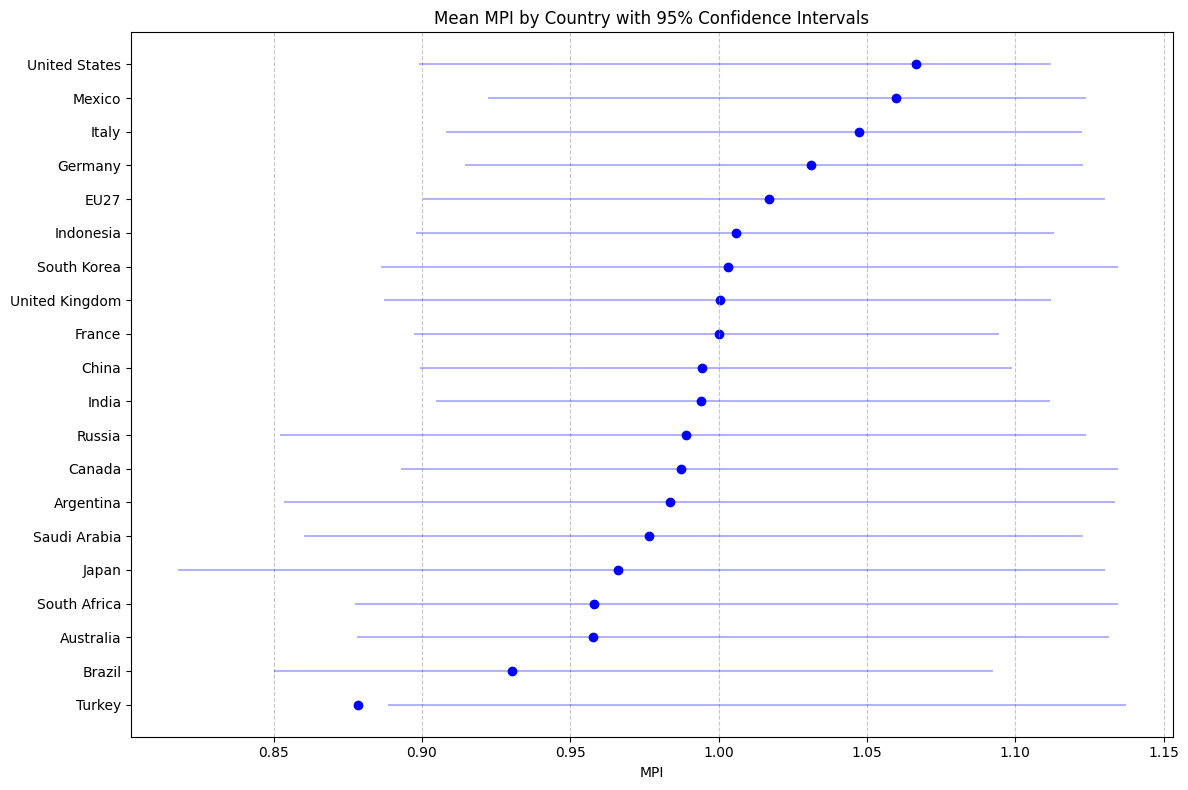

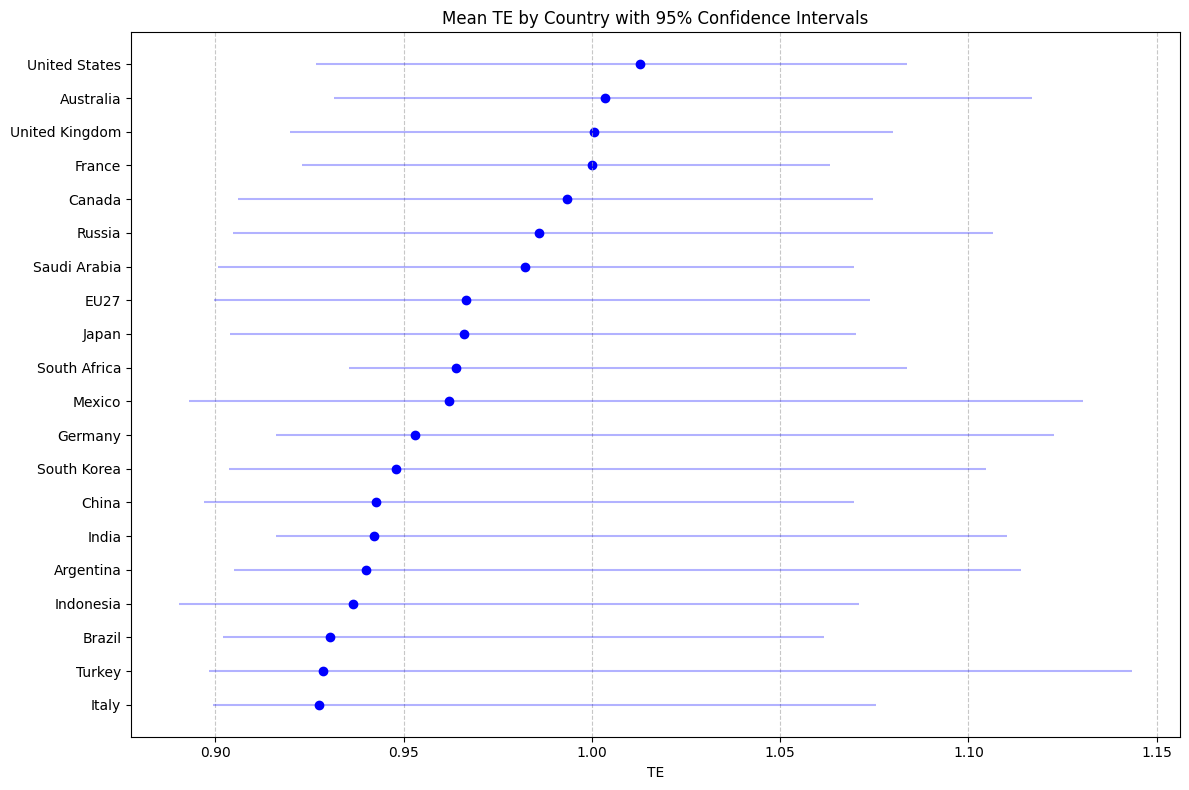

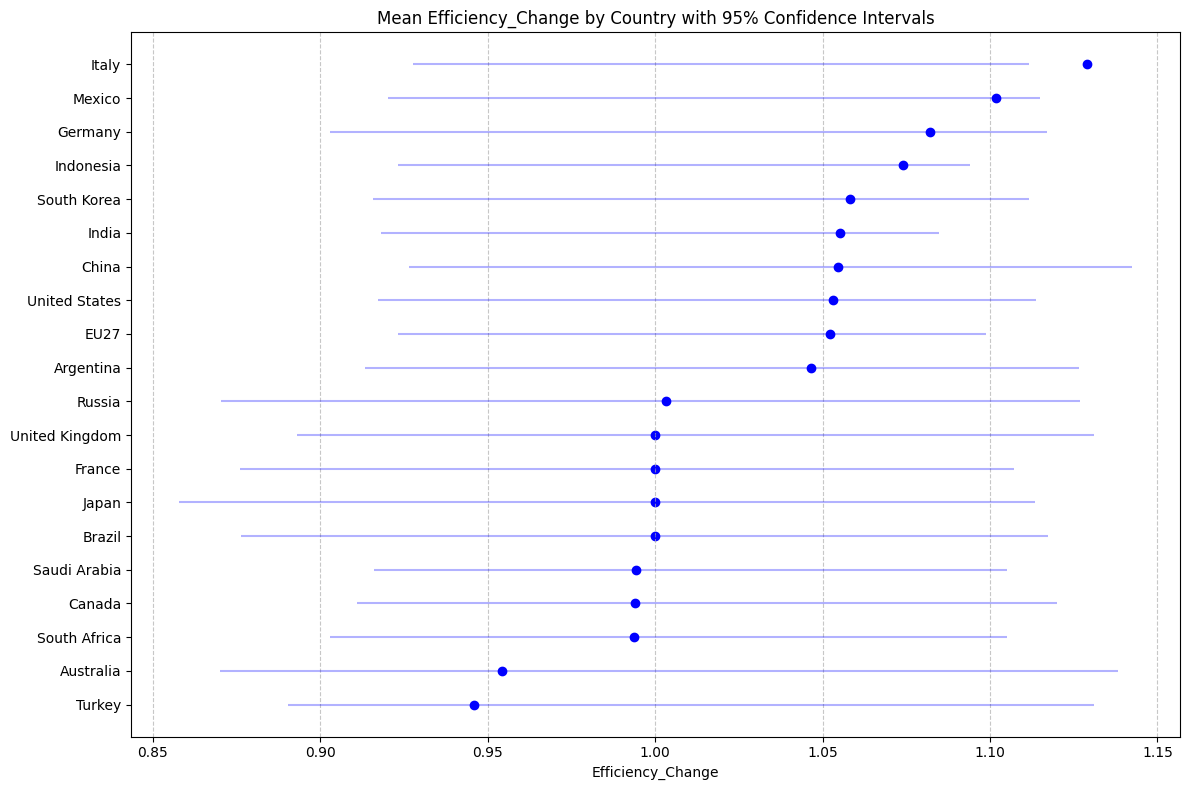

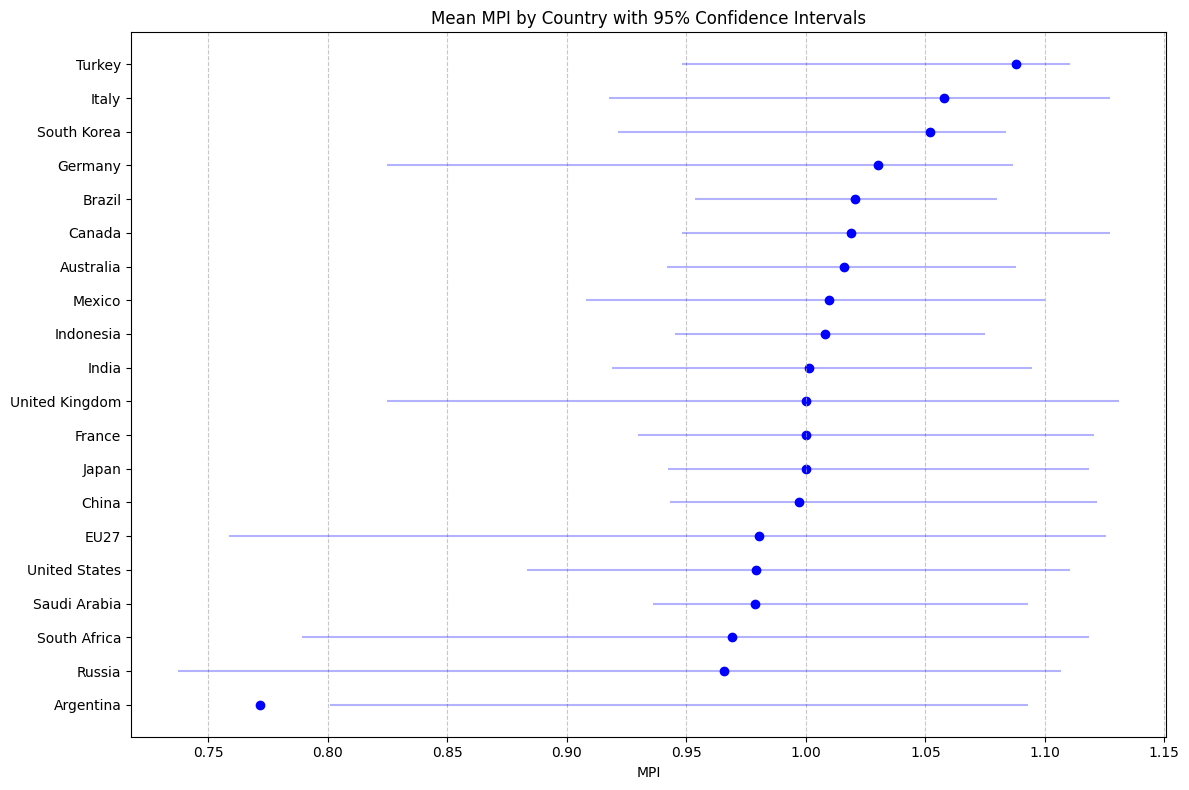

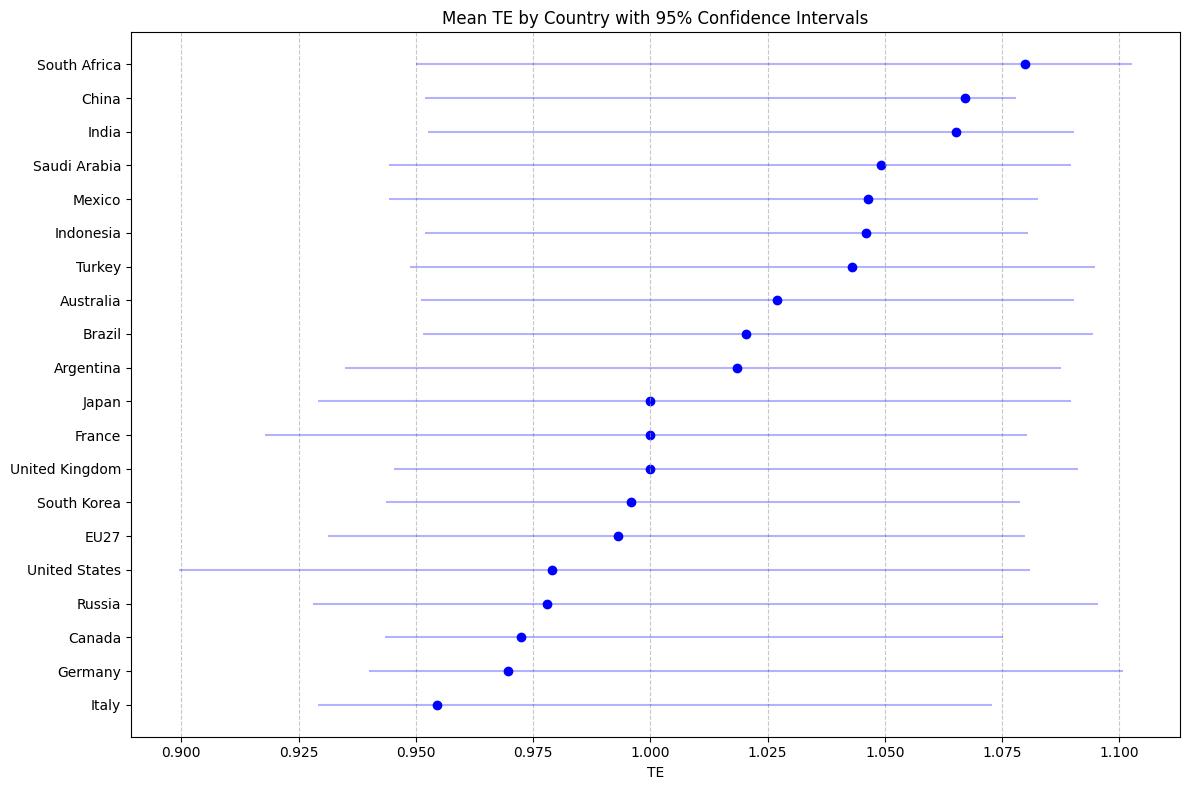

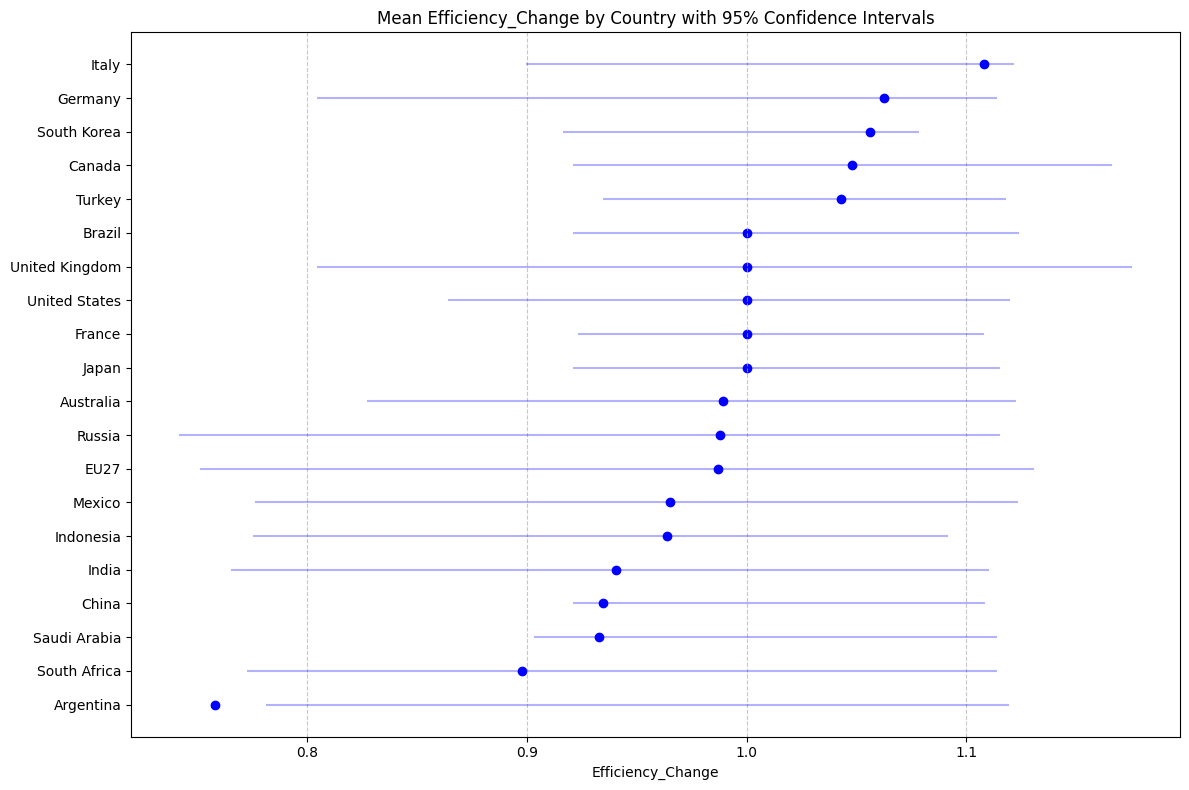

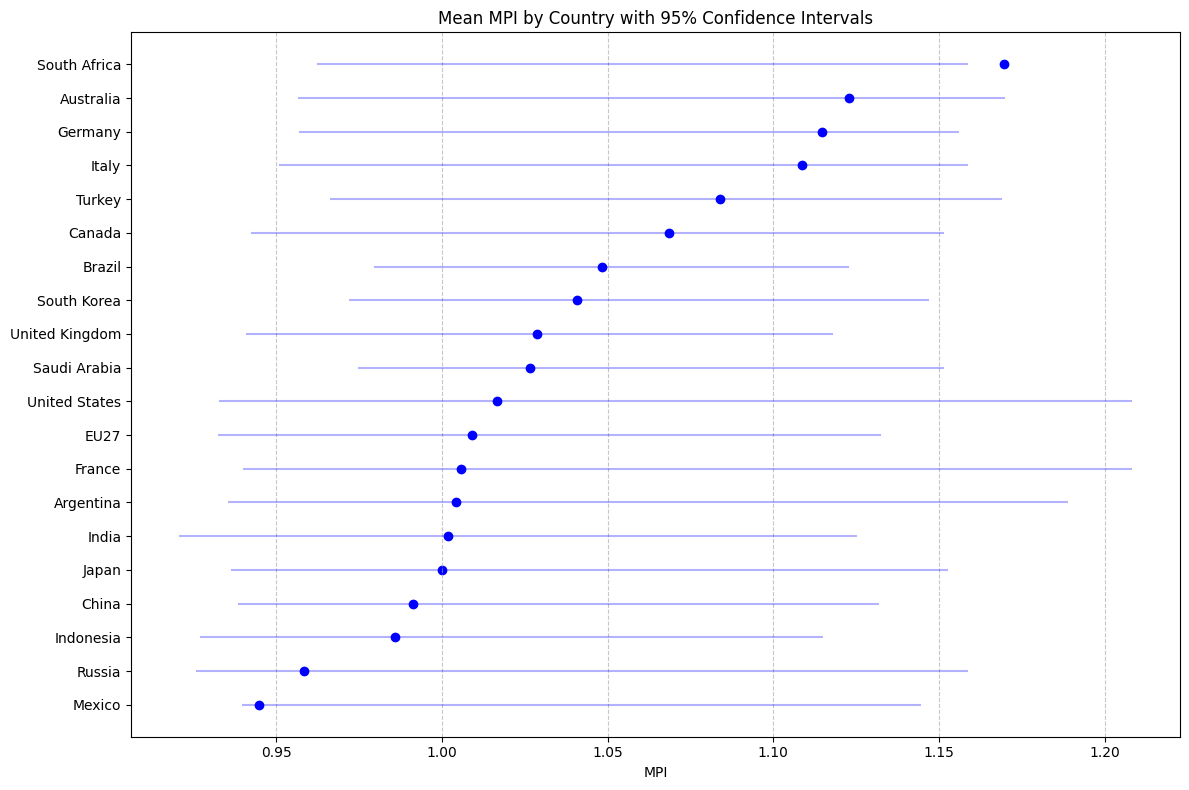

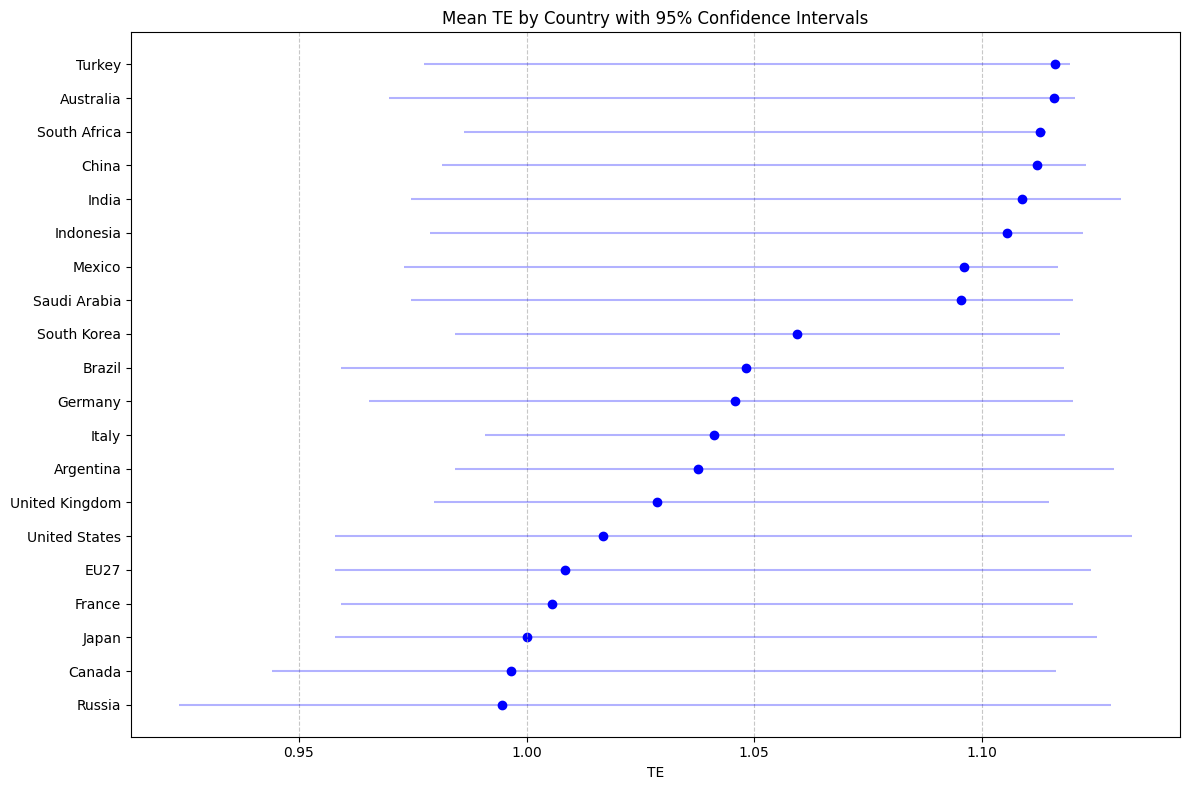

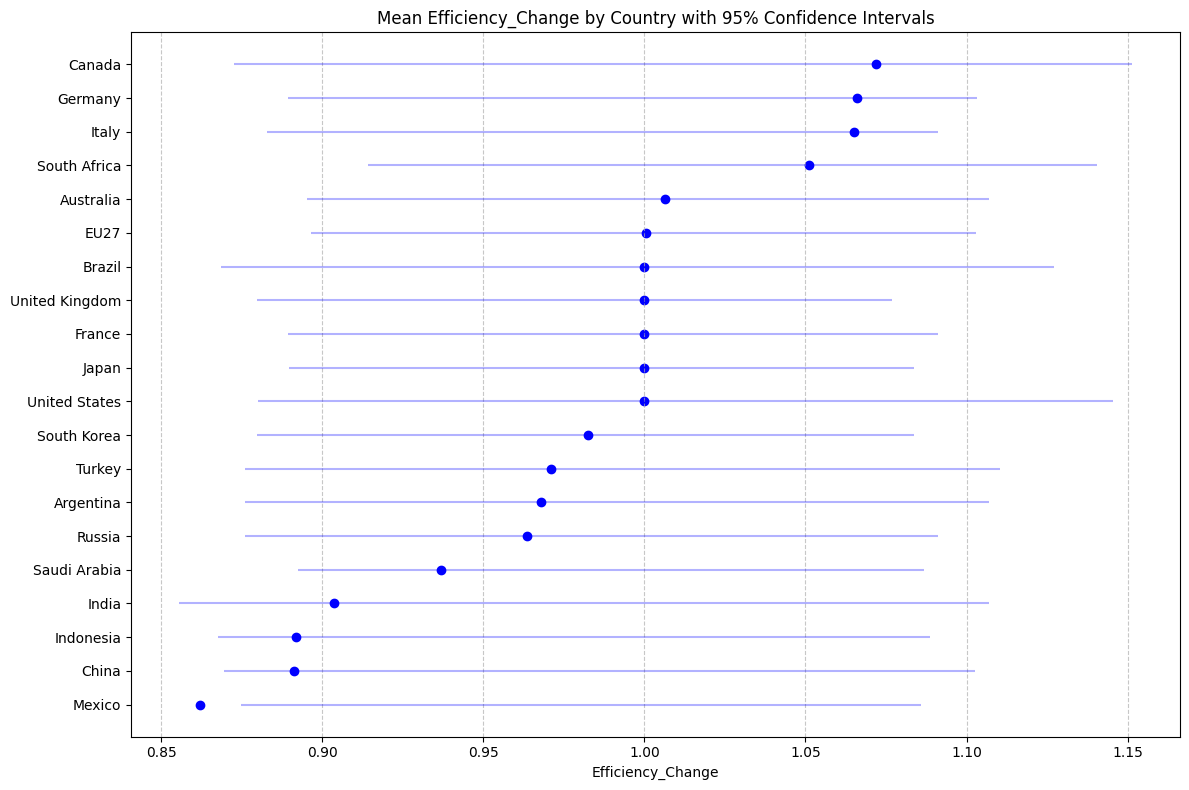

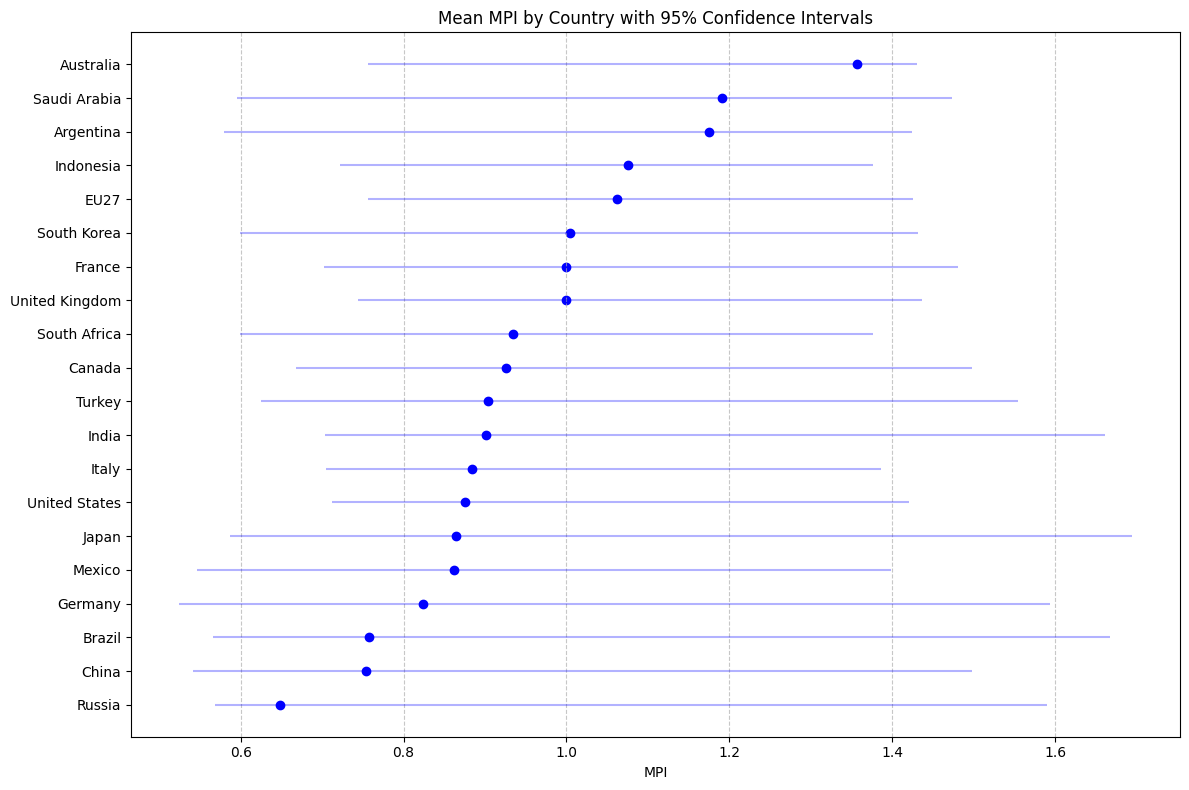

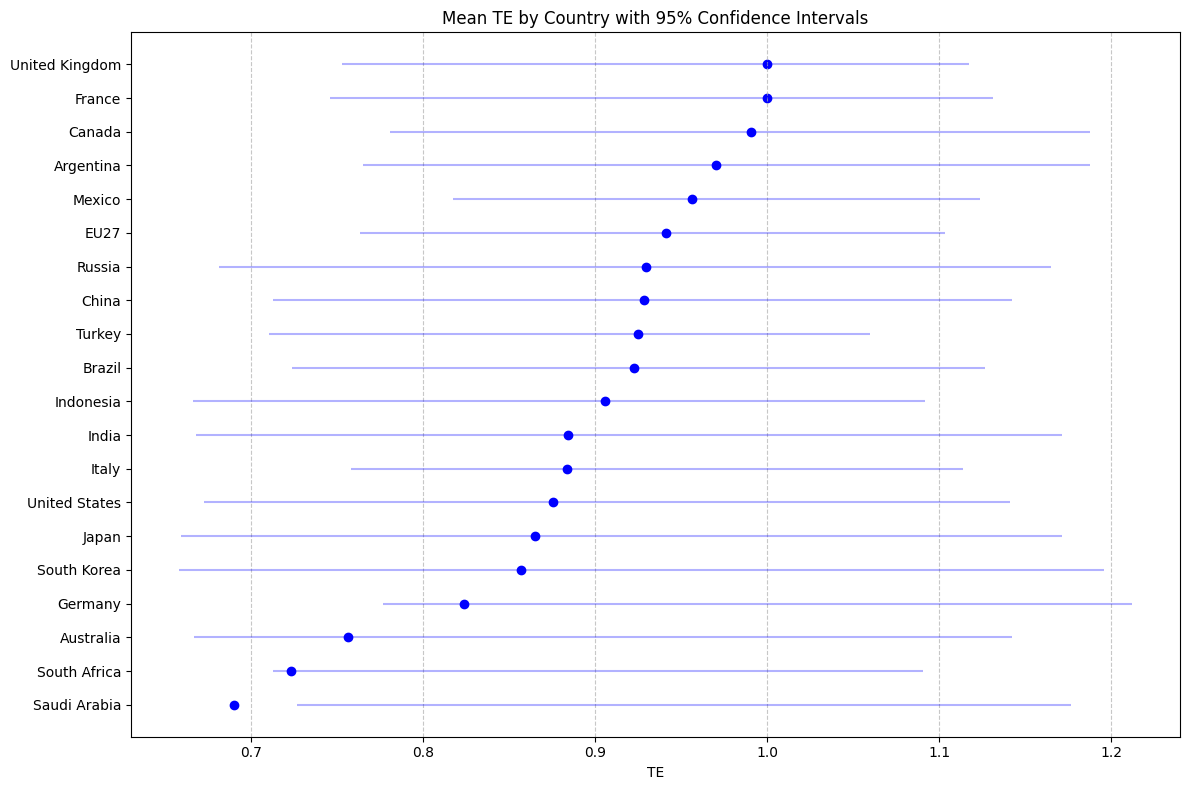

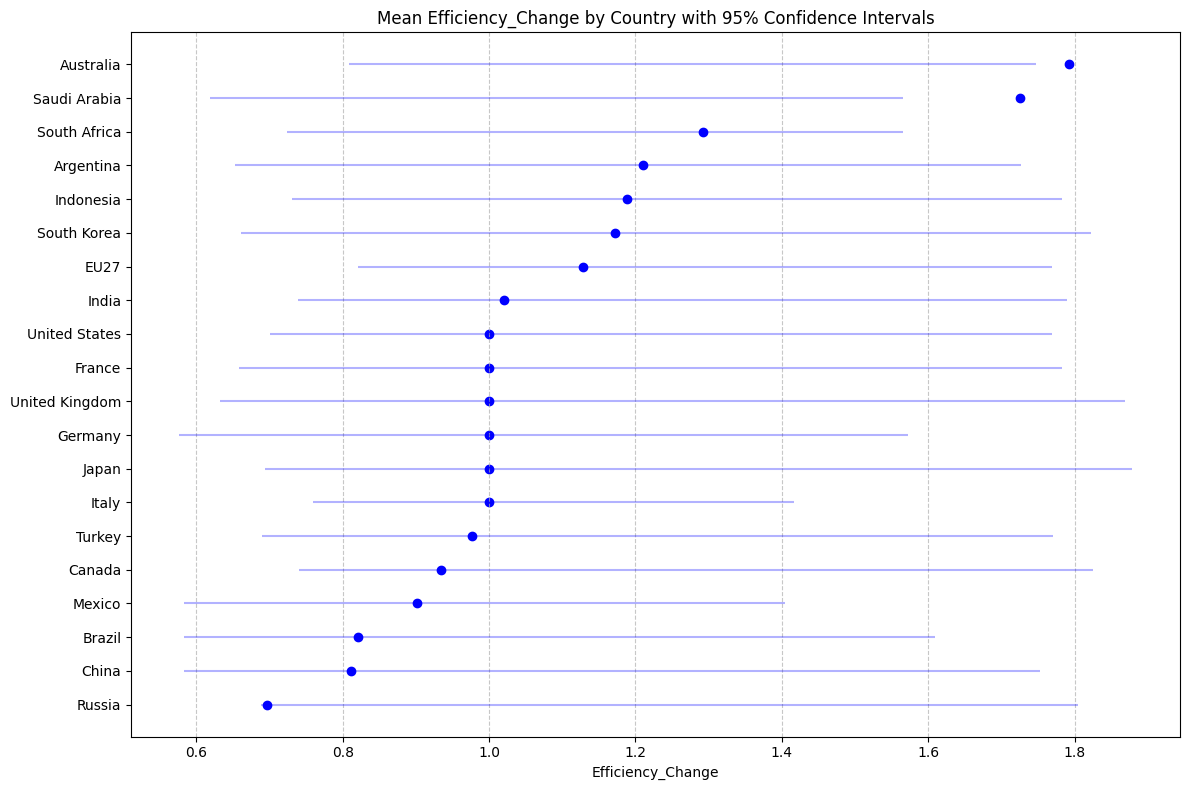

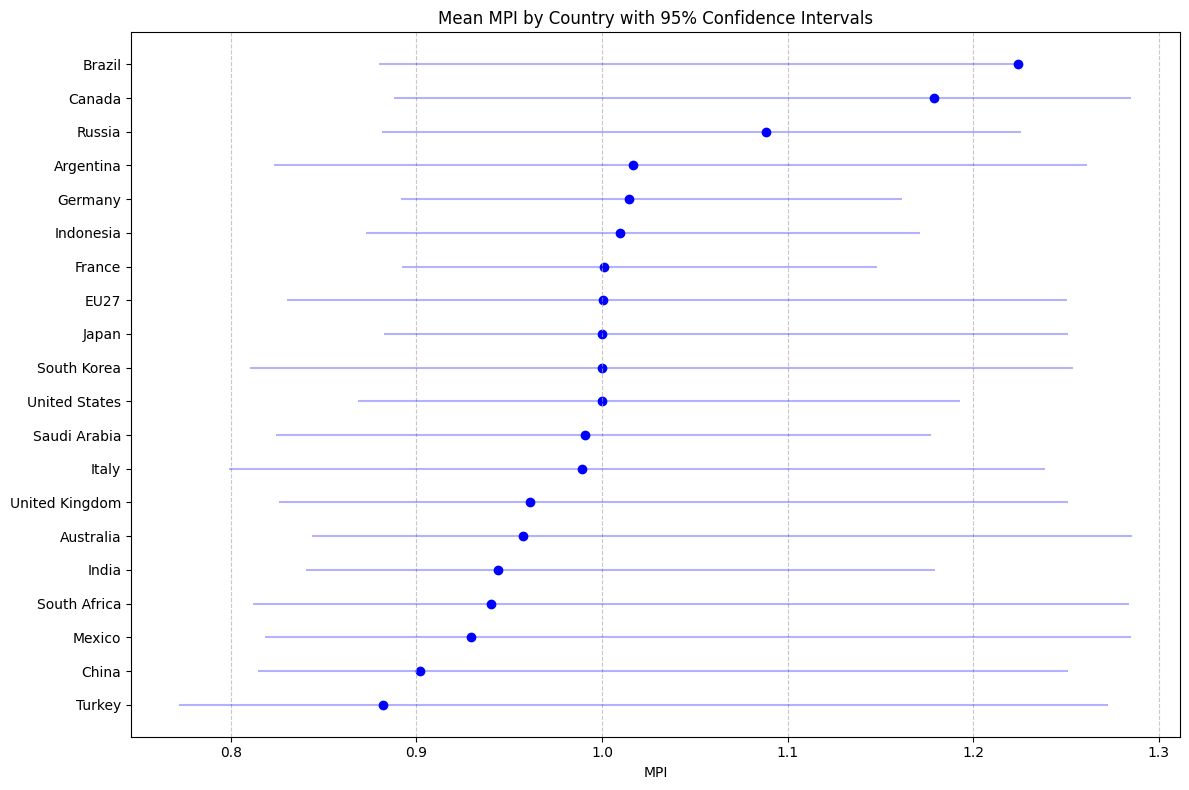

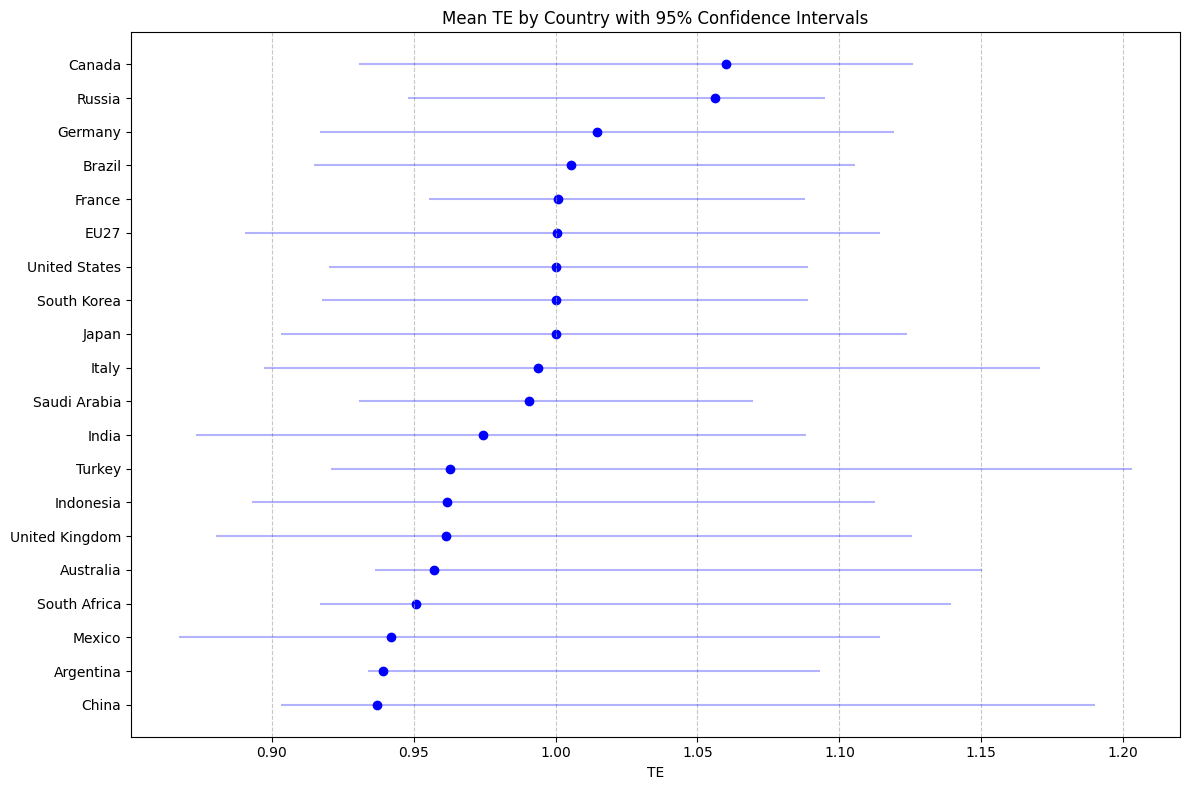

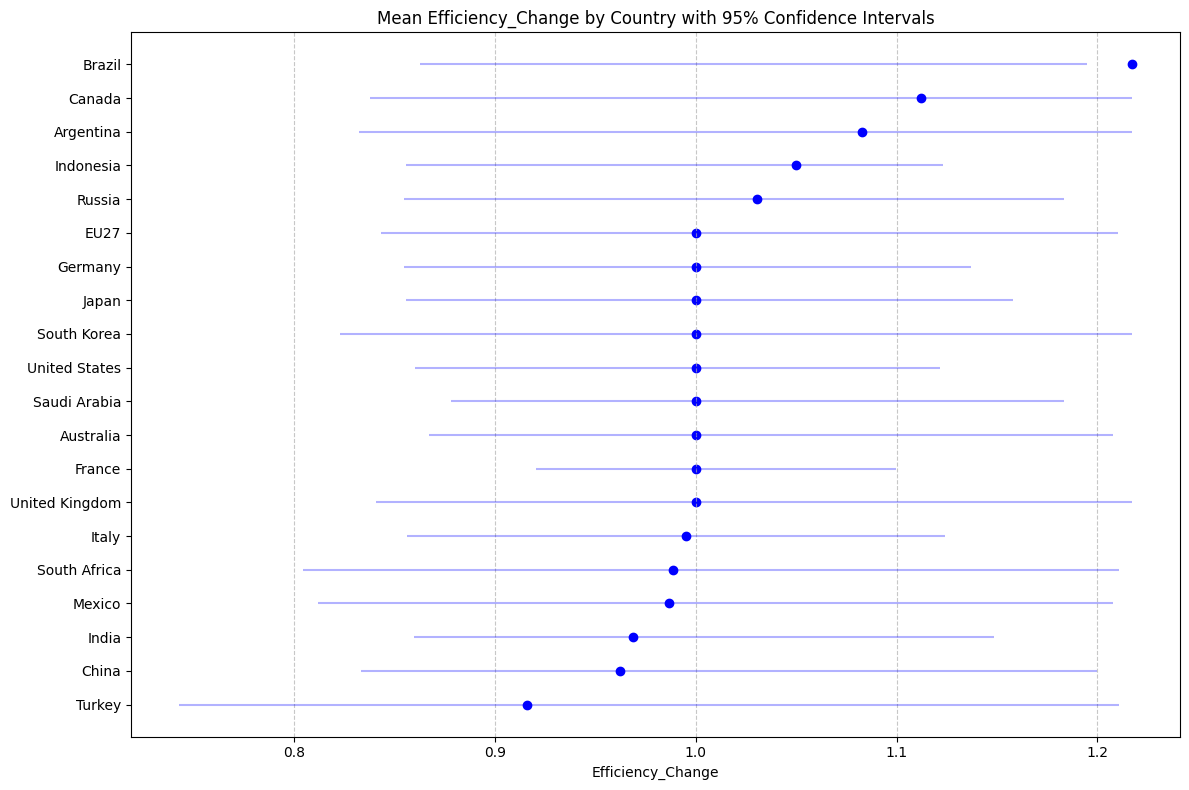

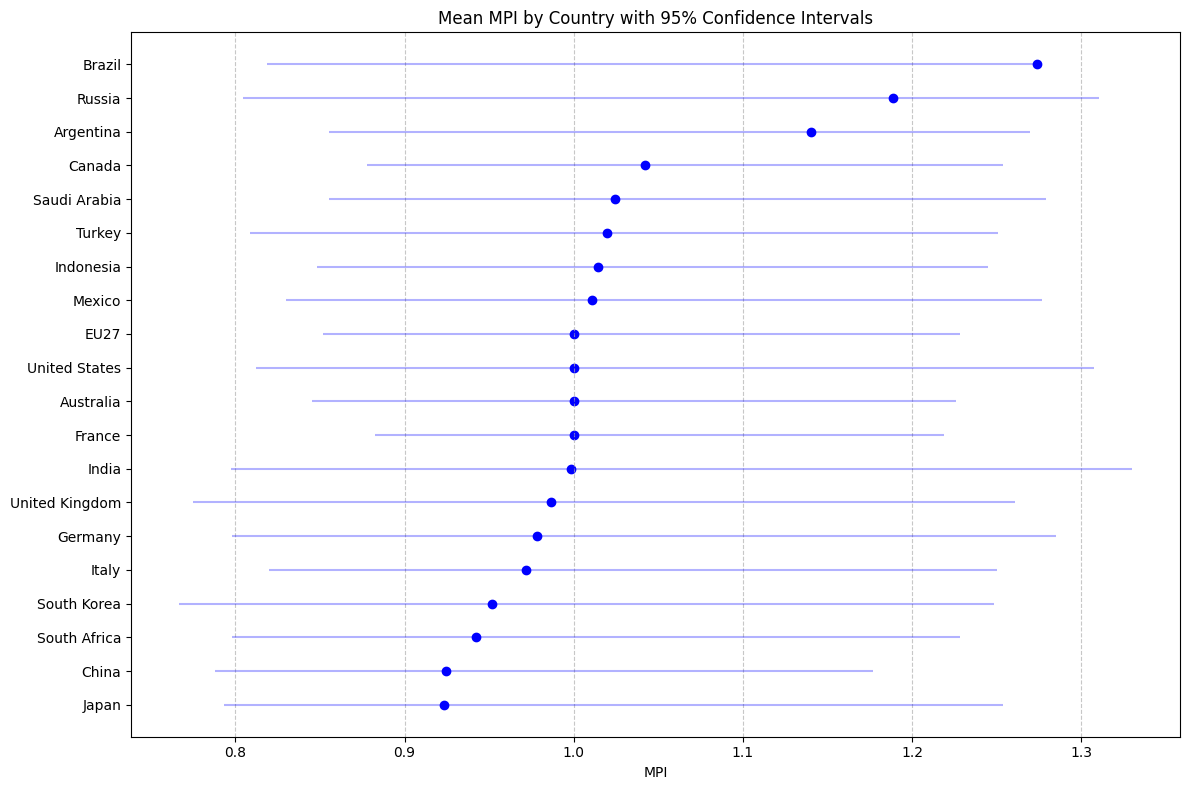

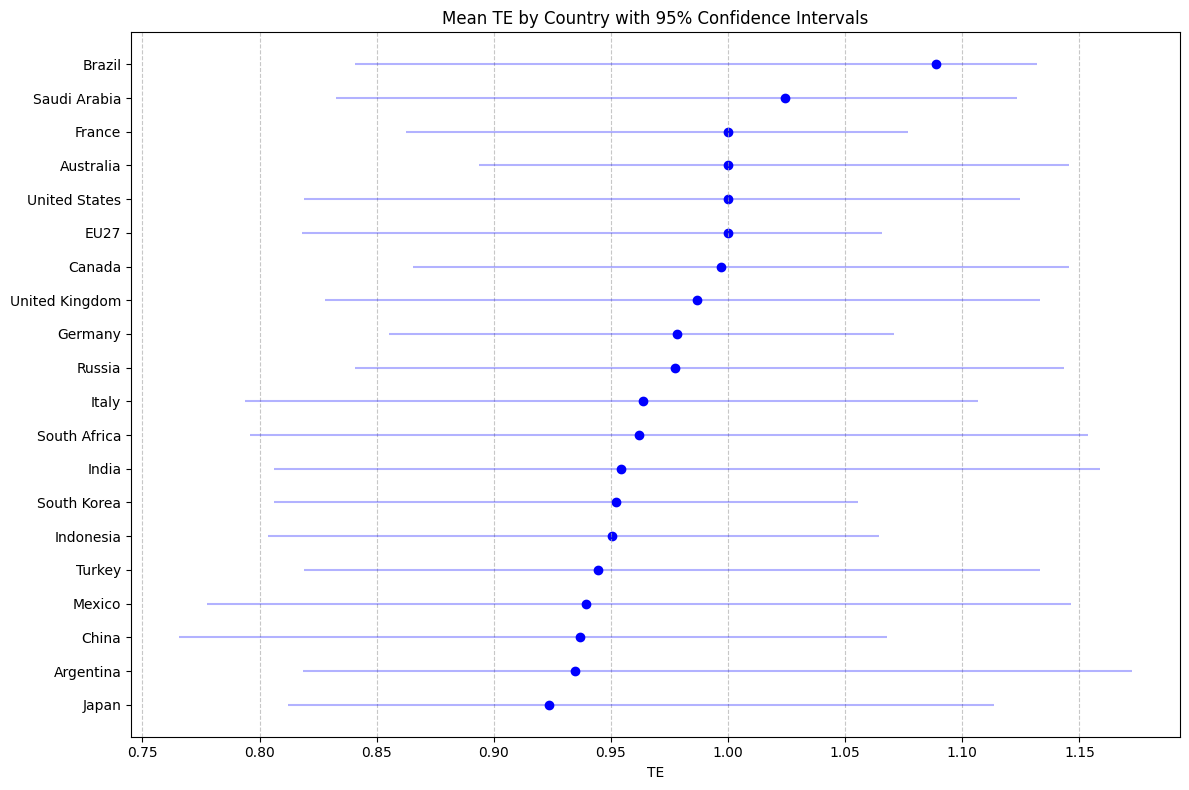

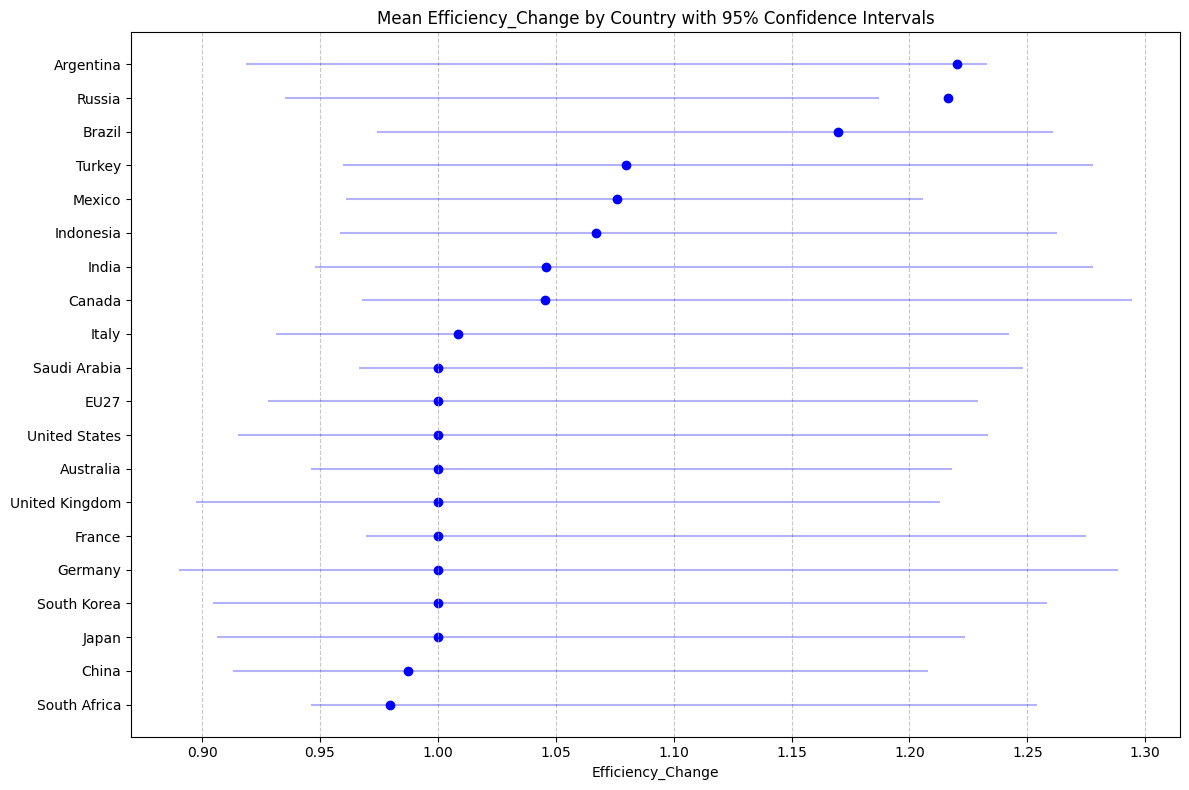

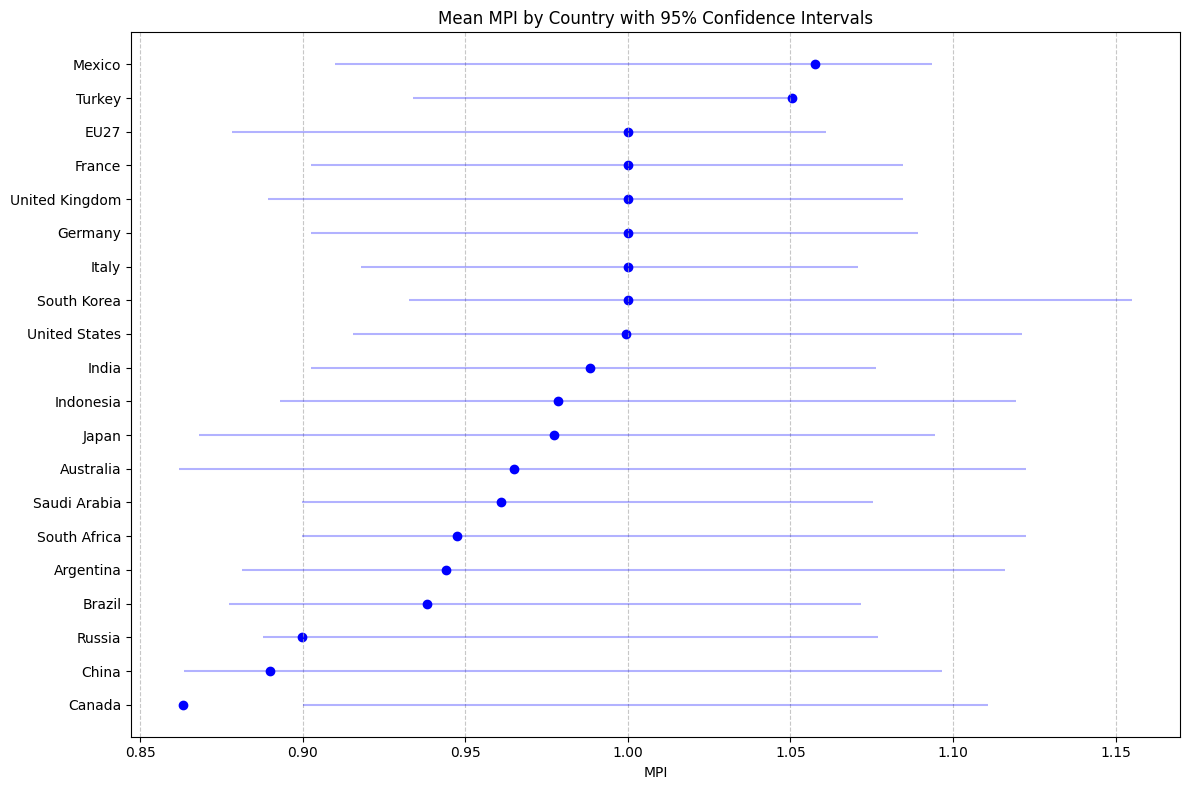

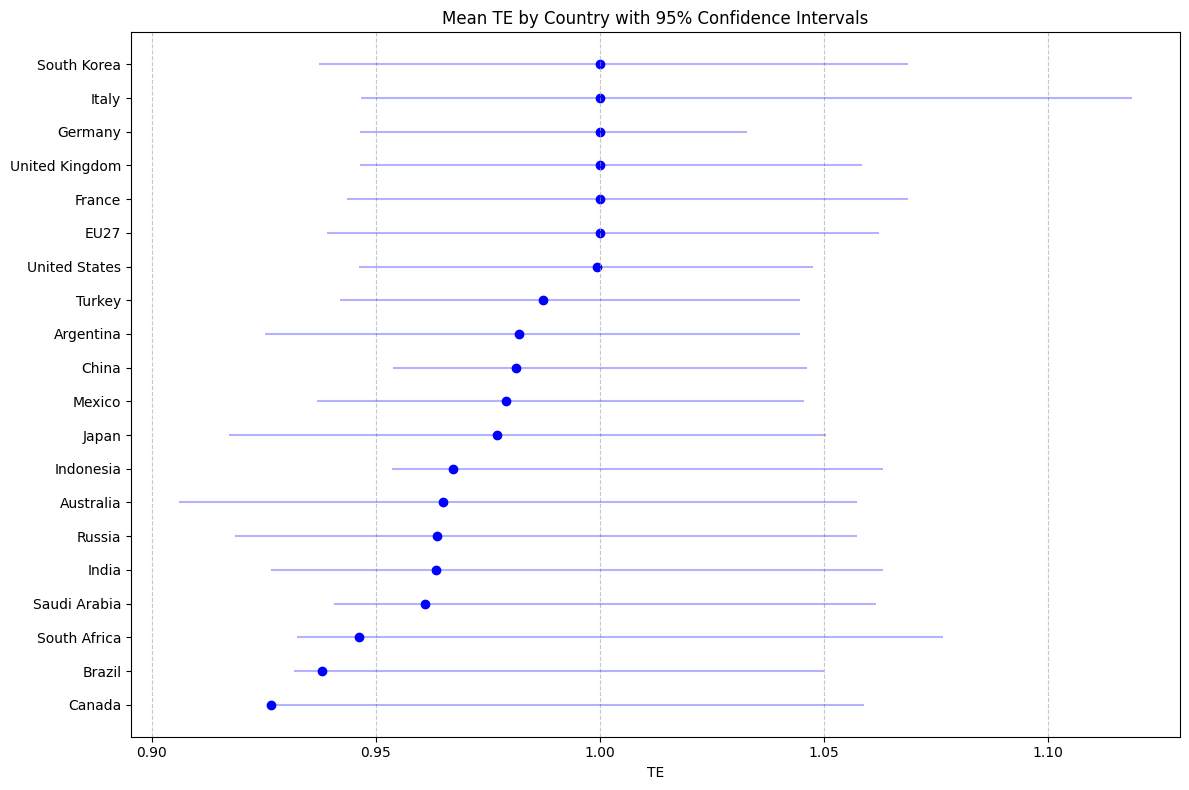

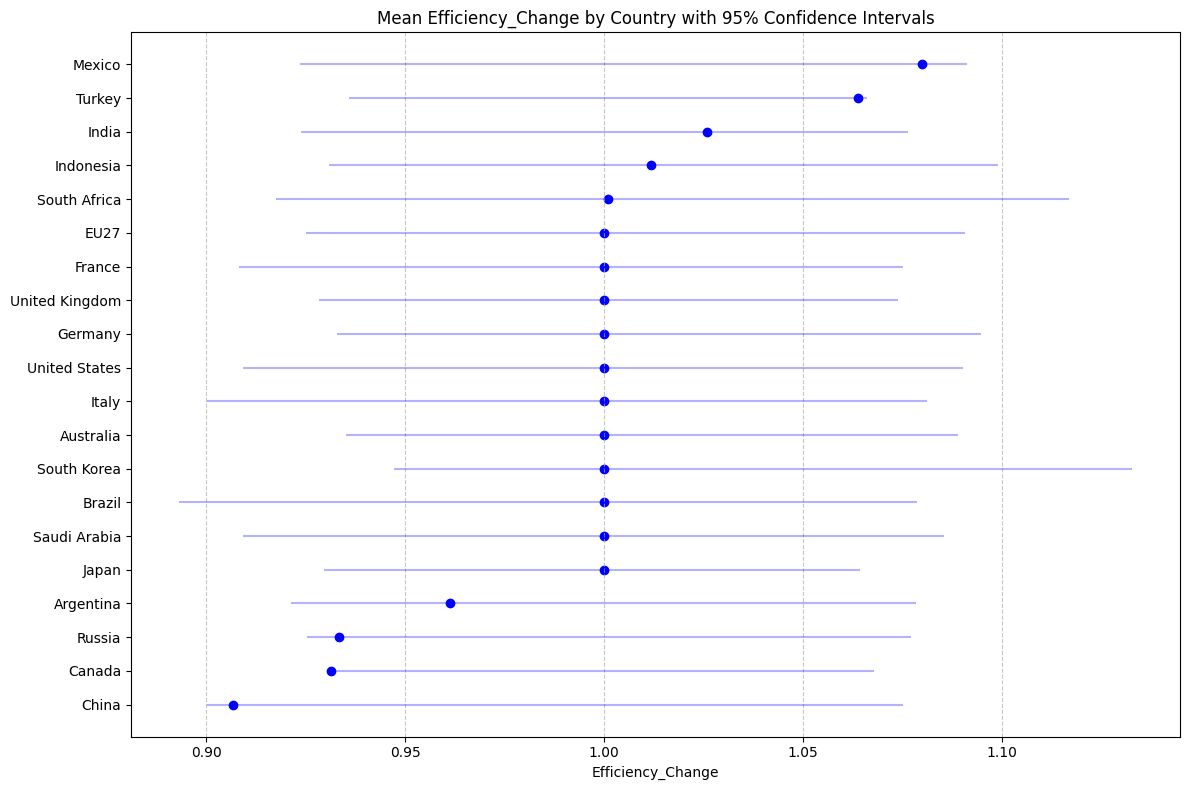

In [26]:
for year1, year2 in [(2000, 2001), (2001, 2002), (2002, 2003),
 (2003, 2015), (2015, 2017), (2021, 2022), (2022,2023)]:
    print ("\n\n\n*************************************")
    print("Analyzing following time period %s %s" % (year1, year2))
    print ("*************************************")
    results, summary, ret = run_all(df, year1, year2)

#run_all(df,2000,2001)